In [51]:
# RwandanFoodAI.ipynb

import os
import shutil
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from sklearn.metrics.pairwise import cosine_similarity
from PIL import Image
from sklearn.utils.class_weight import compute_class_weight

# Suppress TensorFlow warnings
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

In [52]:
# Set up paths
BASE_DIR = os.getcwd()
DATA_DIR = os.path.join(BASE_DIR, "Dataset", "Rwandandishies")
NUTRITION_DATA_PATH = os.path.join(BASE_DIR, "data", "nutrition", "rwandan_food_data.csv")
MODEL_PATH = os.path.join(BASE_DIR, "models", "rwandan_food_model.h5")

In [53]:
# Load the CSV data
df = pd.read_csv(NUTRITION_DATA_PATH)

In [54]:
# 1. Dataset Overview
print(f"Total number of dishes: {len(df)}")
print(f"Columns in the dataset: {', '.join(df.columns)}")

Total number of dishes: 24
Columns in the dataset: name, ingredients, total_calories, protein, carbs, fat, fiber, sodium, sugar


In [55]:
# 1. Dataset Overview
print(f"Total number of dishes: {len(df)}")
print(f"Columns in the dataset: {', '.join(df.columns)}")

Total number of dishes: 24
Columns in the dataset: name, ingredients, total_calories, protein, carbs, fat, fiber, sodium, sugar


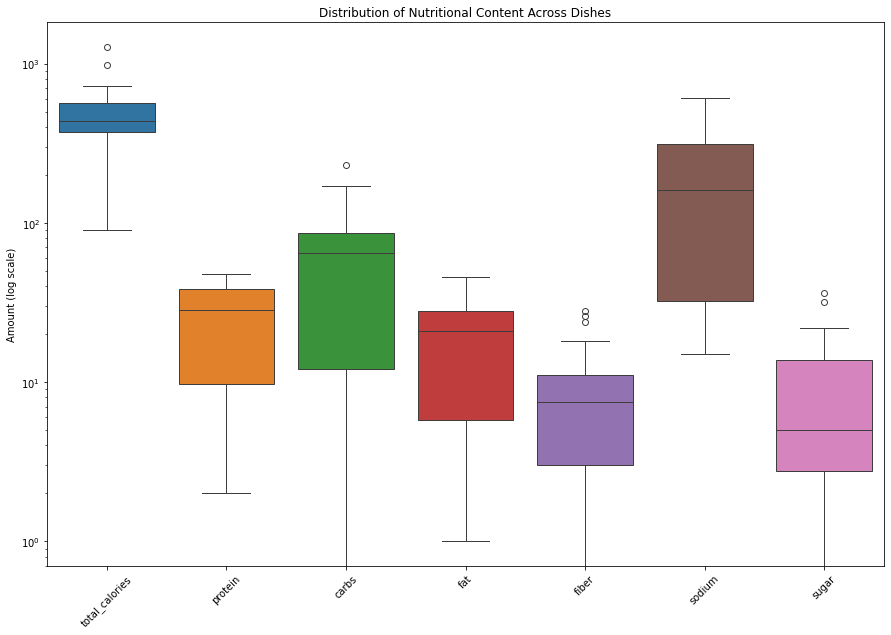

In [56]:
# 2. Nutritional Content Distribution
plt.figure(figsize=(15, 10))
sns.boxplot(data=df[['total_calories', 'protein', 'carbs', 'fat', 'fiber', 'sodium', 'sugar']])
plt.title('Distribution of Nutritional Content Across Dishes')
plt.yscale('log')
plt.ylabel('Amount (log scale)')
plt.xticks(rotation=45)
plt.show()

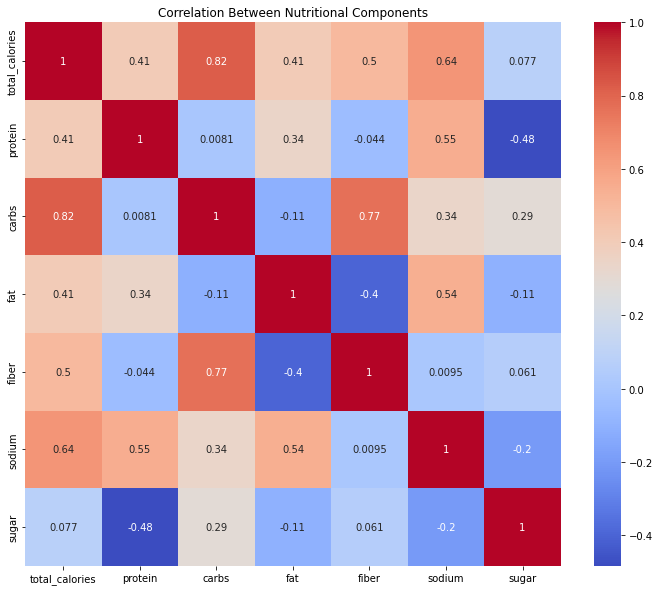

In [57]:
# 3. Correlation Heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(df[['total_calories', 'protein', 'carbs', 'fat', 'fiber', 'sodium', 'sugar']].corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Between Nutritional Components')
plt.show()

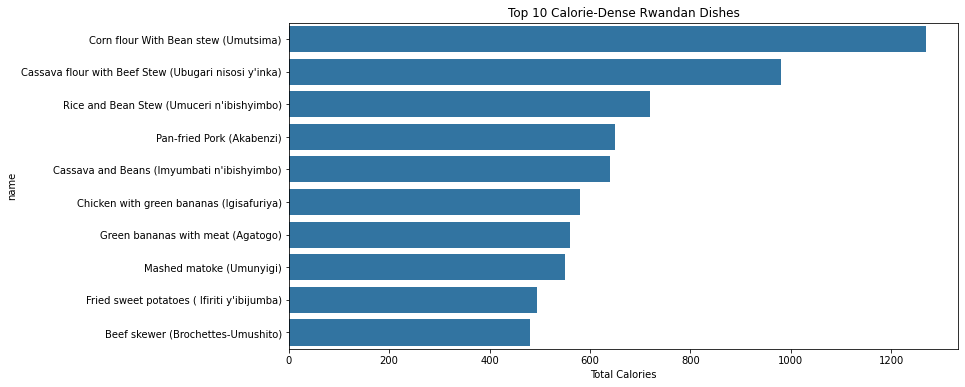

In [58]:
# 4. Top 10 Calorie-Dense Dishes
plt.figure(figsize=(12, 6))
top_10_calories = df.nlargest(10, 'total_calories')
sns.barplot(x='total_calories', y='name', data=top_10_calories)
plt.title('Top 10 Calorie-Dense Rwandan Dishes')
plt.xlabel('Total Calories')
plt.show()

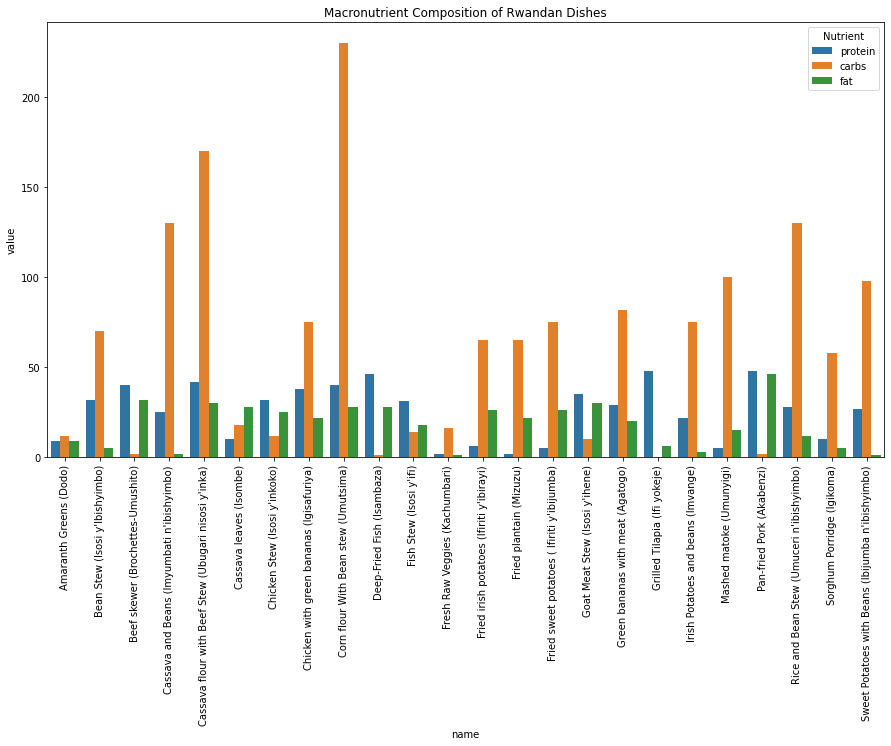

In [59]:
# 5. Macronutrient Composition
plt.figure(figsize=(15, 8))
macronutrients = df[['name', 'protein', 'carbs', 'fat']]
macronutrients_stacked = macronutrients.set_index('name').stack().reset_index()
macronutrients_stacked.columns = ['name', 'nutrient', 'value']
sns.barplot(x='name', y='value', hue='nutrient', data=macronutrients_stacked)
plt.title('Macronutrient Composition of Rwandan Dishes')
plt.xticks(rotation=90)
plt.legend(title='Nutrient')
plt.show()

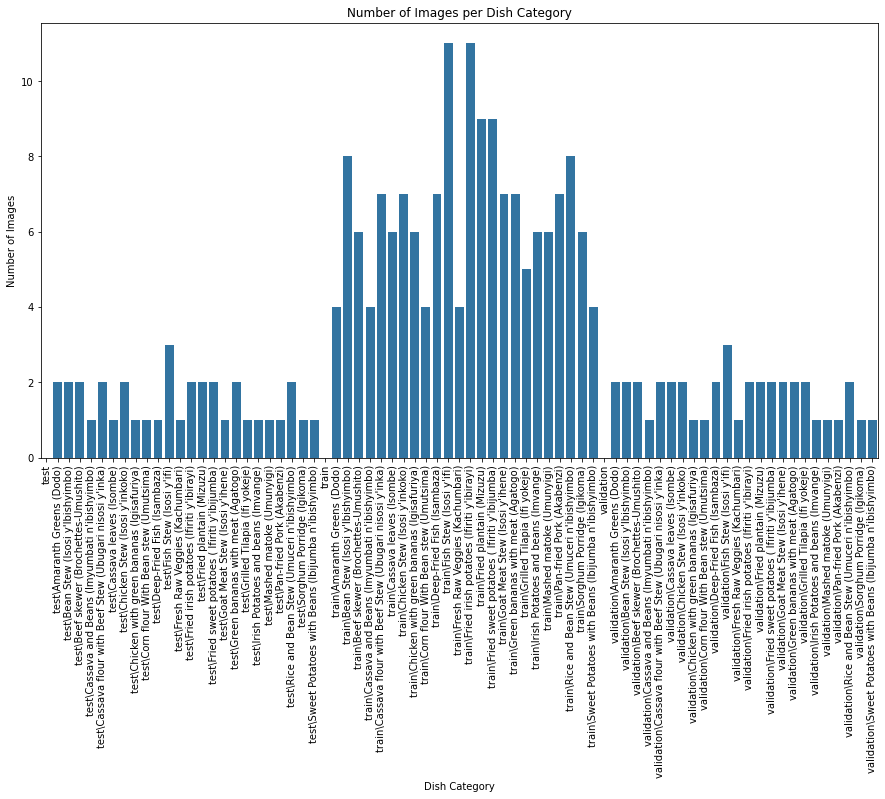

In [60]:
# 6. Image Dataset Analysis
def count_images_in_subfolders(directory):
    image_counts = {}
    for root, dirs, files in os.walk(directory):
        folder_name = os.path.relpath(root, directory)
        if folder_name != '.':
            image_count = len([f for f in files if f.lower().endswith(('.png', '.jpg', '.jpeg', '.gif', '.bmp'))])
            image_counts[folder_name] = image_count
    return image_counts

image_counts = count_images_in_subfolders(DATA_DIR)

plt.figure(figsize=(15, 8))
sns.barplot(x=list(image_counts.keys()), y=list(image_counts.values()))
plt.title('Number of Images per Dish Category')
plt.xlabel('Dish Category')
plt.ylabel('Number of Images')
plt.xticks(rotation=90)
plt.show()

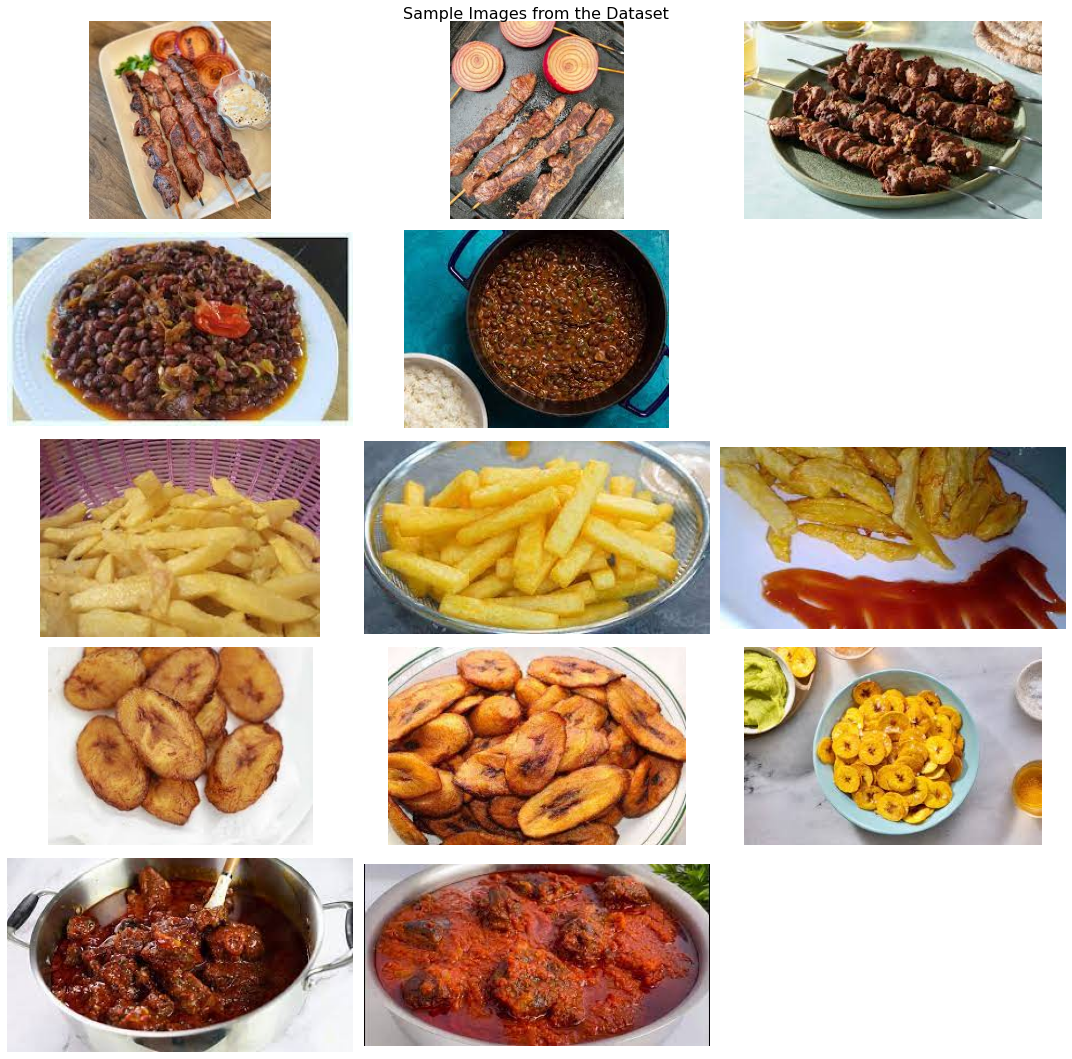

In [61]:
# 7. Sample Images Display
def display_sample_images(data_dir, num_dishes=5, images_per_dish=3):
    subfolders = ['train', 'validation', 'test']
    all_dish_folders = []
    for subfolder in subfolders:
        subfolder_path = os.path.join(data_dir, subfolder)
        dish_folders = [os.path.join(subfolder, f) for f in os.listdir(subfolder_path) if os.path.isdir(os.path.join(subfolder_path, f))]
        all_dish_folders.extend(dish_folders)
    
    num_dishes = min(num_dishes, len(all_dish_folders))
    sample_dishes = np.random.choice(all_dish_folders, num_dishes, replace=False)
    
    fig, axes = plt.subplots(num_dishes, images_per_dish, figsize=(15, 3*num_dishes))
    fig.suptitle('Sample Images from the Dataset', fontsize=16)
    
    if num_dishes == 1:
        axes = axes.reshape(1, -1)
    
    for i, dish_path in enumerate(sample_dishes):
        full_dish_path = os.path.join(data_dir, dish_path)
        images = [f for f in os.listdir(full_dish_path) if f.lower().endswith(('.png', '.jpg', '.jpeg', '.gif', '.bmp'))]
        
        images_to_display = min(images_per_dish, len(images))
        sample_images = np.random.choice(images, images_to_display, replace=False)
        
        for j, img_name in enumerate(sample_images):
            img_path = os.path.join(full_dish_path, img_name)
            img = Image.open(img_path)
            axes[i, j].imshow(img)
            axes[i, j].axis('off')
            if j == 0:
                axes[i, j].set_ylabel(f"{os.path.basename(dish_path)}\n({os.path.dirname(dish_path)})", rotation=0, labelpad=50, va='center')
        
        for j in range(images_to_display, images_per_dish):
            axes[i, j].axis('off')
            axes[i, j].set_visible(False)
    
    plt.tight_layout()
    plt.show()

display_sample_images(DATA_DIR)

In [63]:
# Data Preprocessing
def preprocess_data(data_dir, target_size=(224, 224), batch_size=32):
    train_datagen = ImageDataGenerator(
        rescale=1./255,
        rotation_range=20,
        width_shift_range=0.2,
        height_shift_range=0.2,
        horizontal_flip=True,
    )
    
    validation_datagen = ImageDataGenerator(rescale=1./255)
    test_datagen = ImageDataGenerator(rescale=1./255)
    
    train_generator = train_datagen.flow_from_directory(
        os.path.join(data_dir, 'train'),
        target_size=target_size,
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=True
    )
    
    validation_generator = validation_datagen.flow_from_directory(
        os.path.join(data_dir, 'validation'),
        target_size=target_size,
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=False
    )
    
    test_generator = test_datagen.flow_from_directory(
        os.path.join(data_dir, 'test'),
        target_size=target_size,
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=False
    )
    
    # Compute class weights
    y_train = train_generator.classes
    class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
    class_weight_dict = dict(enumerate(class_weights))
    
    return train_generator, validation_generator, test_generator, class_weight_dict


In [64]:
# Model Creation and Training
def create_model(num_classes):
    base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(1024, activation='relu')(x)
    predictions = Dense(num_classes, activation='softmax')(x)
    model = Model(inputs=base_model.input, outputs=predictions)
    
    for layer in base_model.layers:
        layer.trainable = False
    
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    
    return model

def train_model(model, train_generator, validation_generator, class_weight_dict, epochs=10):
    history = model.fit(
        train_generator,
        steps_per_epoch=train_generator.samples // train_generator.batch_size,
        epochs=epochs,
        validation_data=validation_generator,
        validation_steps=validation_generator.samples // validation_generator.batch_size,
        class_weight=class_weight_dict
    )
    
    return history

Found 159 images belonging to 24 classes.
Found 40 images belonging to 24 classes.
Found 36 images belonging to 24 classes.
Data preprocessing completed.
Number of training samples: 159
Number of validation samples: 40
Number of test samples: 36
Number of classes: 24
Epoch 1/10
4/4 [==============================] - 14s 3s/step - loss: 3.4779 - accuracy: 0.0866 - val_loss: 2.6781 - val_accuracy: 0.2188
Epoch 2/10
4/4 [==============================] - 8s 2s/step - loss: 1.8766 - accuracy: 0.4882 - val_loss: 2.3023 - val_accuracy: 0.4375
Epoch 3/10
4/4 [==============================] - 7s 2s/step - loss: 1.1132 - accuracy: 0.7578 - val_loss: 1.8231 - val_accuracy: 0.4375
Epoch 4/10
4/4 [==============================] - 7s 2s/step - loss: 0.6455 - accuracy: 0.8504 - val_loss: 1.5217 - val_accuracy: 0.5625
Epoch 5/10
4/4 [==============================] - 7s 2s/step - loss: 0.4265 - accuracy: 0.9055 - val_loss: 1.5152 - val_accuracy: 0.5938
Epoch 6/10
4/4 [==============================

c:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\engine\functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


Model saved to c:\Users\User\Nutismart-WebApp\RwandanFoodAI\models\rwandan_food_model.h5


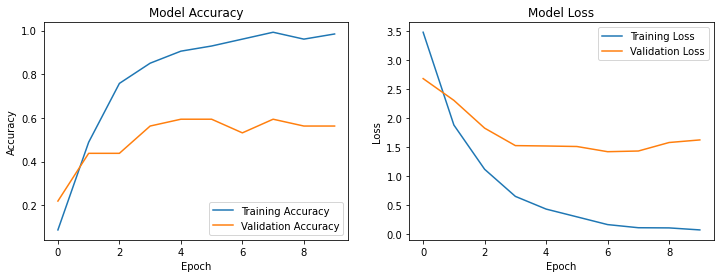

2/2 [==============================] - 2s 218ms/step - loss: 1.2571 - accuracy: 0.7222
Test accuracy: 0.72
Predicted dish: Fish Stew (Isosi y'ifi)
Actual dish: Rice and Bean Stew (Umuceri n'ibishyimbo)


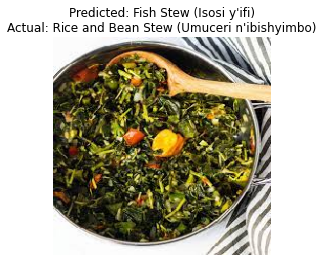


Nutritional Information:
Calories: 330
Protein: 31g
Carbs: 14g
Fat: 18g
Fiber: 4g

Similar dishes you might like:
- Chicken Stew (Isosi y'inkoko)
- Goat Meat Stew (Isosi y'ihene)
- Deep-Fried Fish (Isambaza)
- Beef skewer (Brochettes-Umushito)
- Pan-fried Pork (Akabenzi)


In [65]:
# Main execution
if __name__ == "__main__":
    # Data preprocessing
    train_generator, validation_generator, test_generator, class_weight_dict = preprocess_data(DATA_DIR)
    print("Data preprocessing completed.")
    print(f"Number of training samples: {train_generator.samples}")
    print(f"Number of validation samples: {validation_generator.samples}")
    print(f"Number of test samples: {test_generator.samples}")
    print(f"Number of classes: {len(train_generator.class_indices)}")
    
    # Model training
    num_classes = len(train_generator.class_indices)
    model = create_model(num_classes)
    history = train_model(model, train_generator, validation_generator, class_weight_dict)
    
    # Save the model
    model.save(MODEL_PATH)
    print(f"Model saved to {MODEL_PATH}")
    
    # Plot training history
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

    # Evaluate on test set
    test_loss, test_accuracy = model.evaluate(test_generator)
    print(f"Test accuracy: {test_accuracy:.2f}")

    # Example prediction and recommendation
    test_images = next(test_generator)[0]
    test_labels = next(test_generator)[1]
    predictions = model.predict(test_images)
    predicted_class = np.argmax(predictions[0])
    true_class = np.argmax(test_labels[0])
    
    class_names = list(train_generator.class_indices.keys())
    predicted_dish = class_names[predicted_class]
    true_dish = class_names[true_class]
    
    print(f"Predicted dish: {predicted_dish}")
    print(f"Actual dish: {true_dish}")
    
    # Display the sample image
    plt.imshow(test_images[0])
    plt.title(f"Predicted: {predicted_dish}\nActual: {true_dish}")
    plt.axis('off')
    plt.show()
    
    # Nutritional information
    dish_info = df[df['name'] == predicted_dish].iloc[0]
    print("\nNutritional Information:")
    print(f"Calories: {dish_info['total_calories']}")
    print(f"Protein: {dish_info['protein']}g")
    print(f"Carbs: {dish_info['carbs']}g")
    print(f"Fat: {dish_info['fat']}g")
    print(f"Fiber: {dish_info['fiber']}g")
    
    # Simple recommendation based on similar nutritional content
    df['similarity'] = df[['protein', 'carbs', 'fat', 'fiber']].apply(lambda row: cosine_similarity([row], [dish_info[['protein', 'carbs', 'fat', 'fiber']]])[0][0], axis=1)
    recommendations = df.sort_values('similarity', ascending=False).iloc[1:6]['name'].tolist()
    
    print("\nSimilar dishes you might like:")
    for dish in recommendations:
        print(f"- {dish}")